In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("maltegrosse/8-m-spotify-tracks-genre-audio-features")

print("Path to dataset files:", path)

Path to dataset files: /Users/akovel/.cache/kagglehub/datasets/maltegrosse/8-m-spotify-tracks-genre-audio-features/versions/1


In [2]:
import pandas as pd
import sqlite3

In [3]:
db_path = path + "/spotify.sqlite"

In [4]:
con = sqlite3.connect(db_path)
con.text_factory = lambda x: x.decode(encoding='utf-8',errors = 'ignore')
cur = con.cursor()

cur.execute("SELECT name FROM sqlite_master  WHERE type='table';")
print(cur.fetchall())

[('albums',), ('artists',), ('audio_features',), ('genres',), ('r_albums_artists',), ('r_albums_tracks',), ('r_artist_genre',), ('r_track_artist',), ('tracks',)]


In [5]:
rArtistGenre = pd.read_sql_query("SELECT * FROM r_artist_genre", con)
rAlbumsTracks = pd.read_sql_query("SELECT * FROM r_albums_tracks", con)
albums = pd.read_sql_query("SELECT * from albums", con)
artists = pd.read_sql_query("SELECT * from artists", con)
audio_features = pd.read_sql_query("SELECT * from audio_features", con)
tracks = pd.read_sql_query("SELECT * from tracks", con)
rAlbumsArtists = pd.read_sql_query("SELECT * from r_albums_artists", con)

In [6]:
rArtistGenre.head().to_dict()

{'genre_id': {0: 'detroit hip hop',
  1: 'g funk',
  2: 'gangster rap',
  3: 'hardcore hip hop',
  4: 'hip hop'},
 'artist_id': {0: '4tujQJicOnuZRLiBFdp3Ou',
  1: '4tujQJicOnuZRLiBFdp3Ou',
  2: '4tujQJicOnuZRLiBFdp3Ou',
  3: '4tujQJicOnuZRLiBFdp3Ou',
  4: '4tujQJicOnuZRLiBFdp3Ou'}}

In [7]:
albums = albums.sort_values(by='popularity',ascending=False)

In [8]:
albums_merge_artists = pd.merge(rAlbumsArtists,albums,left_on='album_id',right_on='id')
albums_merge_artists.drop(['id'],axis=1,inplace=True)
albums_merge_artists.sort_values(by='popularity',ascending=False,inplace=True)
albums_merge_artists.rename(columns={'name':'albumName'},inplace=True)
albums_merge_artists.drop_duplicates(subset=['albumName','artist_id'],inplace=True)

In [9]:
MergedData = pd.merge(rAlbumsTracks,albums_merge_artists[albums_merge_artists['album_type']!='single'])
MergedData = pd.merge(MergedData,audio_features,left_on='track_id',right_on='id')
MergedData = MergedData.drop(['id'],axis=1)
MergedData = pd.merge(MergedData,artists[['name','id']],left_on='artist_id',right_on='id')
MergedData = MergedData.drop(['id'],axis=1)
MergedData = MergedData.rename(columns={'name':'artistName'})
MergedData = MergedData.sort_values(by=['popularity'],ascending=False)

In [10]:
import pickle

In [11]:
def storeData(df):
    dbfile = open('MergedData','ab')
    pickle.dump(df, dbfile)
    dbfile.close()

storeData(MergedData)

In [12]:
def loadData():
    # for reading also binary mode is important
    dbfile = open('MergedData', 'rb')
    db = pickle.load(dbfile)
    dbfile.close()
    return db

MergedData = loadData()

# EDA

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [14]:
MergedData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9183746 entries, 2025448 to 6575440
Data columns (total 23 columns):
 #   Column            Dtype  
---  ------            -----  
 0   album_id          object 
 1   track_id          object 
 2   artist_id         object 
 3   albumName         object 
 4   album_group       object 
 5   album_type        object 
 6   release_date      int64  
 7   popularity        int64  
 8   acousticness      float64
 9   analysis_url      object 
 10  danceability      float64
 11  duration          int64  
 12  energy            float64
 13  instrumentalness  float64
 14  key               int64  
 15  liveness          float64
 16  loudness          float64
 17  mode              int64  
 18  speechiness       float64
 19  tempo             float64
 20  time_signature    int64  
 21  valence           float64
 22  artistName        object 
dtypes: float64(9), int64(6), object(8)
memory usage: 1.6+ GB


Для начала нужно решить, что мы делаем с отрицательными значениями времени. Для этого перейдем по ссылкам и посмотрим оригинальную дату, а затем постараемся проследить, как именно она конвертировалась.

<Axes: >

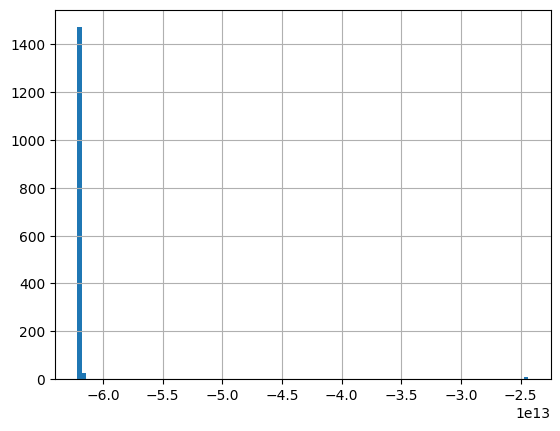

In [15]:
MergedData['release_date'][MergedData['release_date'] < -3000000000000].hist(bins=100) # в datetime

In [16]:
MergedData[MergedData['release_date']< -3000000000000].sort_values('release_date').head()

,album_id,track_id,artist_id,albumName,album_group,album_type,release_date,popularity,acousticness,analysis_url,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artistName
4343952,5ZR3wCUhSc0Bbb6V4dRGfT,7cojTNCd9RypNCTL4QP5n8,5RiBm9eRvtBsrxCGre3f6G,芸能生活40周年企画 シングルパーフェクトコレクション(4枚組),,album,-62135769600000,43,0.662,https://api.spotify.com/v1/audio-analysis/7coj...,...,0.000011,2,0.150,-8.907000,0,0.0293,138.270004,4,0.373,Ikuzo Yoshi
2359446,55GvEdVhcqtXphA7yqj2LL,5rzCHOVmyRCycufIRUgc2V,6h9jT7zebwhWjLjOLkamau,2017 Midwest Clinic: Martin High School Sympho...,,album,-62135769600000,1,0.927,https://api.spotify.com/v1/audio-analysis/5rzC...,...,0.658000,5,0.758,-18.360001,1,0.0406,86.775002,4,0.196,Jamie Ovalle
2359447,55GvEdVhcqtXphA7yqj2LL,5rzCHOVmyRCycufIRUgc2V,1X4zMNcyf3hTdIngstP31n,2017 Midwest Clinic: Martin High School Sympho...,,album,-62135769600000,1,0.927,https://api.spotify.com/v1/audio-analysis/5rzC...,...,0.658000,5,0.758,-18.360001,1,0.0406,86.775002,4,0.196,Michael Stringer
2359448,55GvEdVhcqtXphA7yqj2LL,5rzCHOVmyRCycufIRUgc2V,62D5baBIwtoV9KTNLS3qLj,2017 Midwest Clinic: Martin High School Sympho...,,album,-62135769600000,1,0.927,https://api.spotify.com/v1/audio-analysis/5rzC...,...,0.658000,5,0.758,-18.360001,1,0.0406,86.775002,4,0.196,Caitlin Ravkind
2359449,55GvEdVhcqtXphA7yqj2LL,5rzCHOVmyRCycufIRUgc2V,22CutSmQRL9xqvFPeq1h1i,2017 Midwest Clinic: Martin High School Sympho...,,album,-62135769600000,1,0.927,https://api.spotify.com/v1/audio-analysis/5rzC...,...,0.658000,5,0.758,-18.360001,1,0.0406,86.775002,4,0.196,Samuel Branch


In [17]:
f"{np.round(MergedData[MergedData['release_date'] < -3000000000000].shape[0] / MergedData.shape[0] * 100, 2)}% от нашего датасета"

'0.02% от нашего датасета'

Перейдя по ссылкам на сам Spotify, заметим, что дата выпуска либо вызывает сомнения (некоторые артисты датировали так самостоятельно, хотя другие песни их деятельности датированы современными годами), либо закралась ошибка в самом датасете, ибо дата не совпадает с карточкой трека. Оба этих случая выкинем из рассмотрения, так как они занимают всего 0.02% всех данных.

In [19]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
MergedData = MergedData[MergedData['release_date'] > -3000000000000]

Описание числовых признаков, например, длительности, танцевальности, энергии и других характеристик треков.

In [20]:
MergedData.describe() # В более понятный float

,release_date,popularity,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,9182239.00000,9182239.00000,9182239.00000,9182239.00000,9182239.00000,9182239.00000,9182239.00000,9182239.00000,9182239.00000,9182239.00000,9182239.00000,9182239.00000,9182239.00000,9182239.00000,9182239.00000
mean,1185574531063.10840,14.73742,0.48863,0.50738,236675.16635,0.49679,0.27481,5.21152,0.20682,-12.08342,0.66872,0.09456,116.67675,3.81298,0.45884
std,406746261937.77454,15.92226,0.38793,0.19747,161784.92886,0.29501,0.37738,3.52798,0.18246,7.05541,0.47067,0.14202,31.57346,0.61096,0.28615
min,-2587680000000.00000,0.00000,0.00000,0.00000,1000.00000,0.00000,0.00000,0.00000,0.00000,-60.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1086048000000.00000,1.00000,0.06410,0.36200,163677.00000,0.23400,0.00000,2.00000,0.09670,-15.92700,0.00000,0.03630,92.90500,4.00000,0.20400
50%,1304380800000.00000,10.00000,0.49100,0.52000,213499.00000,0.50300,0.00338,5.00000,0.13000,-10.15800,1.00000,0.04640,115.93300,4.00000,0.44400
75%,1435017600000.00000,24.00000,0.90300,0.66000,274213.00000,0.75300,0.70800,8.00000,0.26100,-6.80100,1.00000,0.07790,136.00700,4.00000,0.69900
max,1619136000000.00000,100.00000,0.99600,1.00000,6072187.00000,1.00000,1.00000,11.00000,1.00000,6.27500,1.00000,0.97400,249.98700,5.00000,1.00000


In [21]:
MergedData.columns

Index(['album_id', 'track_id', 'artist_id', 'albumName', 'album_group',
       'album_type', 'release_date', 'popularity', 'acousticness',
       'analysis_url', 'danceability', 'duration', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'artistName'],
      dtype='object')

In [27]:
MergedData.isnull().sum()

album_id            0
track_id            0
artist_id           0
albumName           0
album_group         0
album_type          0
release_date        0
popularity          0
acousticness        0
analysis_url        0
danceability        0
duration            0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
artistName          0
release_year        0
dtype: int64

Рассмотрим распределение релизов по годам

In [22]:
unique_tracks_index = MergedData['track_id'][~MergedData['track_id'].duplicated()].index

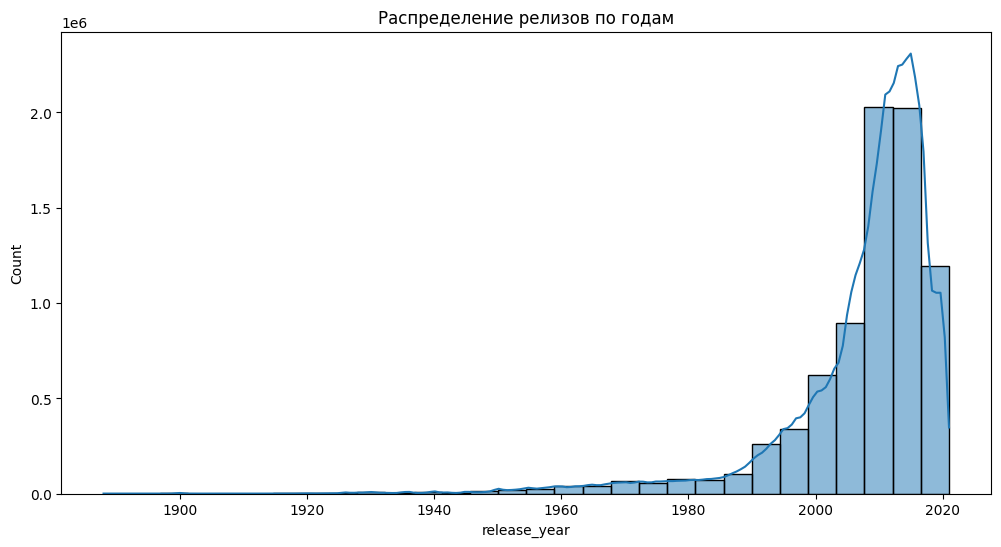

In [23]:
MergedData['release_year'] = pd.to_datetime(MergedData['release_date'], unit='ms').dt.year
plt.figure(figsize=(12, 6))
sns.histplot(MergedData.loc[unique_tracks_index]['release_year'], bins=30, kde=True)
plt.title("Распределение релизов по годам")
plt.show()

Заметим, что больше всего релизов было выпущено в 2010-ые года. При учете популярности треков в дальнейшем, вероятно, будет необходимо нормализовавыть прослушиваемость треков на выпуск.

Популярность треков в зависимости от года выпуска.

/var/folders/zz/gp2ff22x0kd0hxvd61_3_hc00000gn/T/ipykernel_40895/2837283312.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=popularity_counts.index, y=popularity_counts.values, palette='viridis')


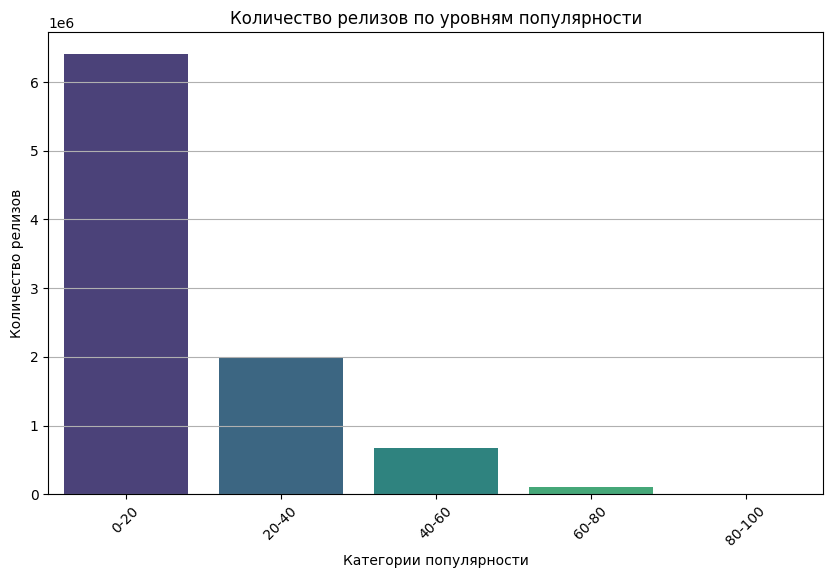

In [31]:
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
MergedData['popularity_category'] = pd.cut(MergedData['popularity'], bins=bins, labels=labels, include_lowest=True)

# Подсчитываем количество релизов в каждой категории
popularity_counts = MergedData['popularity_category'].value_counts().sort_index()

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=popularity_counts.index, y=popularity_counts.values, palette='viridis')
plt.title('Количество релизов по уровням популярности')
plt.xlabel('Категории популярности')
plt.ylabel('Количество релизов')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Этот график нам говорит, что популрынх релизов мало. И на самом деле показывает немного информации. 

## Разделим датасет на жанры

In [36]:
merged_generes_data = pd.merge(MergedData, rArtistGenre, on="artist_id", how="left")

In [39]:
merged_generes_data.head()

,album_id,track_id,artist_id,albumName,album_group,album_type,release_date,popularity,acousticness,analysis_url,...,loudness,mode,speechiness,tempo,time_signature,valence,artistName,release_year,popularity_category,genre_id
0,5dGWwsZ9iB2Xc3UKR0gif2,0oaY19dUwZimIgzn3ZZLZO,1uNFoZAHBGtllmzznpCI3s,Justice,,album,1616112000000,100,0.59300,https://api.spotify.com/v1/audio-analysis/0oaY...,...,-8.60100,1,0.04560,119.59000,4,0.16700,Justin Bieber,1616,80-100,canadian pop
1,5dGWwsZ9iB2Xc3UKR0gif2,0oaY19dUwZimIgzn3ZZLZO,1uNFoZAHBGtllmzznpCI3s,Justice,,album,1616112000000,100,0.59300,https://api.spotify.com/v1/audio-analysis/0oaY...,...,-8.60100,1,0.04560,119.59000,4,0.16700,Justin Bieber,1616,80-100,pop
2,5dGWwsZ9iB2Xc3UKR0gif2,0oaY19dUwZimIgzn3ZZLZO,1uNFoZAHBGtllmzznpCI3s,Justice,,album,1616112000000,100,0.59300,https://api.spotify.com/v1/audio-analysis/0oaY...,...,-8.60100,1,0.04560,119.59000,4,0.16700,Justin Bieber,1616,80-100,post-teen pop
3,5dGWwsZ9iB2Xc3UKR0gif2,4iJyoBOLtHqaGxP12qzhQI,1uNFoZAHBGtllmzznpCI3s,Justice,,album,1616112000000,100,0.32100,https://api.spotify.com/v1/audio-analysis/4iJy...,...,-6.18100,1,0.11900,90.03000,4,0.46400,Justin Bieber,1616,80-100,canadian pop
4,5dGWwsZ9iB2Xc3UKR0gif2,4iJyoBOLtHqaGxP12qzhQI,1uNFoZAHBGtllmzznpCI3s,Justice,,album,1616112000000,100,0.32100,https://api.spotify.com/v1/audio-analysis/4iJy...,...,-6.18100,1,0.11900,90.03000,4,0.46400,Justin Bieber,1616,80-100,pop


/var/folders/zz/gp2ff22x0kd0hxvd61_3_hc00000gn/T/ipykernel_40895/3598416021.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_popularity.index, y=genre_popularity.values, palette='viridis')


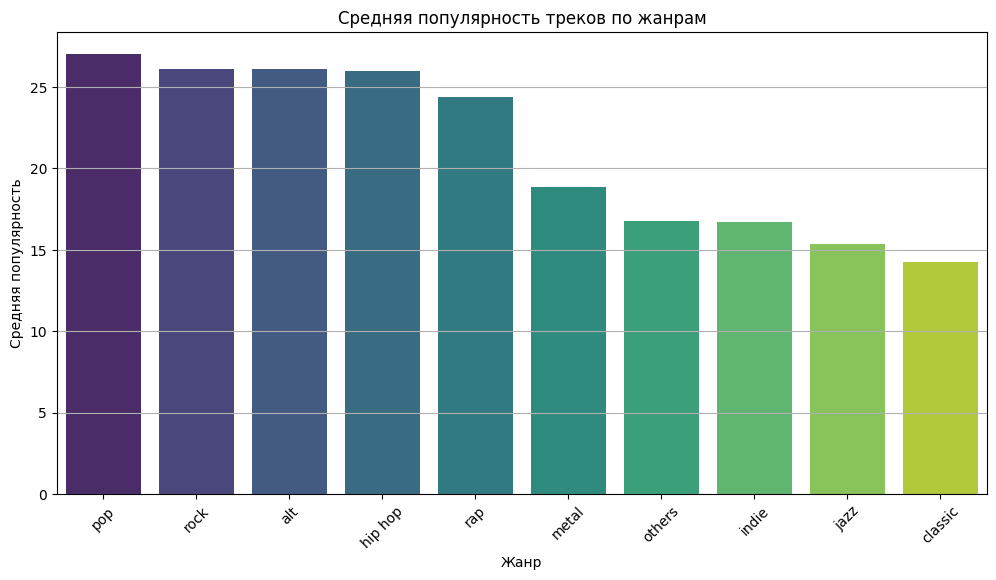

In [42]:
known_genres = ['pop', 'rock', 'metal', 'rap', 'hip hop', 'classic', 'alt', 'jazz', 'indie']
def assign_main_genre(row):
    if isinstance(row['genre_id'], str):
        for genre in known_genres:
            if genre in row['genre_id']:
                return genre
    return 'others'

merged_generes_data['main_genre'] = merged_generes_data.apply(assign_main_genre, axis=1)

genre_popularity = merged_generes_data.groupby('main_genre')['popularity'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_popularity.index, y=genre_popularity.values, palette='viridis')
plt.title('Средняя популярность треков по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Средняя популярность')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

С попом всё ясно, на то он и называется поп. Никогда не понимал чем отличается hip hop и rap, но hip hop популярнее рэпа.

Самая локальная тусовка - джазовиков и классиков. 

## Продемонстрируем анализ музыкальных характеристик треков.

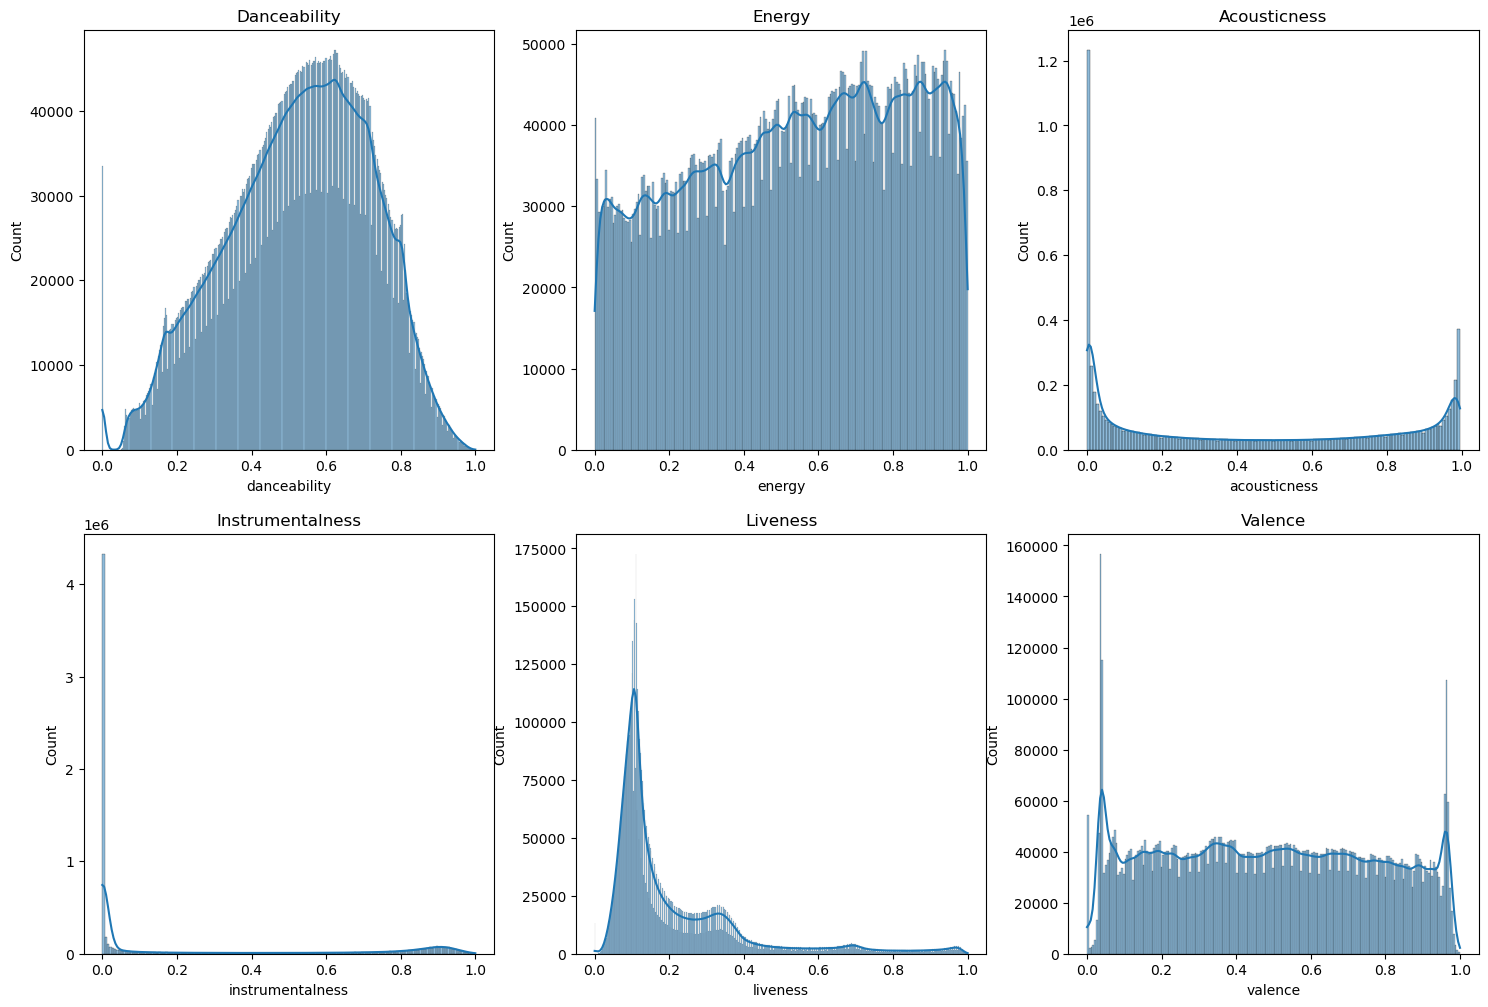

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sns.histplot(MergedData.loc[unique_tracks_index]['danceability'], ax=axes[0, 0], kde=True)
sns.histplot(MergedData.loc[unique_tracks_index]['energy'], ax=axes[0, 1], kde=True)
sns.histplot(MergedData.loc[unique_tracks_index]['acousticness'], ax=axes[0, 2], kde=True)
sns.histplot(MergedData.loc[unique_tracks_index]['instrumentalness'], ax=axes[1, 0], kde=True)
sns.histplot(MergedData.loc[unique_tracks_index]['liveness'], ax=axes[1, 1], kde=True)
sns.histplot(MergedData.loc[unique_tracks_index]['valence'], ax=axes[1, 2], kde=True)
axes[0, 0].set_title("Danceability")
axes[0, 1].set_title("Energy")
axes[0, 2].set_title("Acousticness")
axes[1, 0].set_title("Instrumentalness")
axes[1, 1].set_title("Liveness")
axes[1, 2].set_title("Valence")
plt.show()



При рекомендации треков можно учитывать характеристики самих песен - например, танцевальность песни визуально следует нормальному распределению, а значит, чтобы попасть в ядро аудитории вечеринки, нужно брать песни со средними значениями, повышая вероятность зацепить их любимую песню.

/var/folders/zz/gp2ff22x0kd0hxvd61_3_hc00000gn/T/ipykernel_40895/3877390782.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_genres.index, x=top_genres.values, palette="viridis")


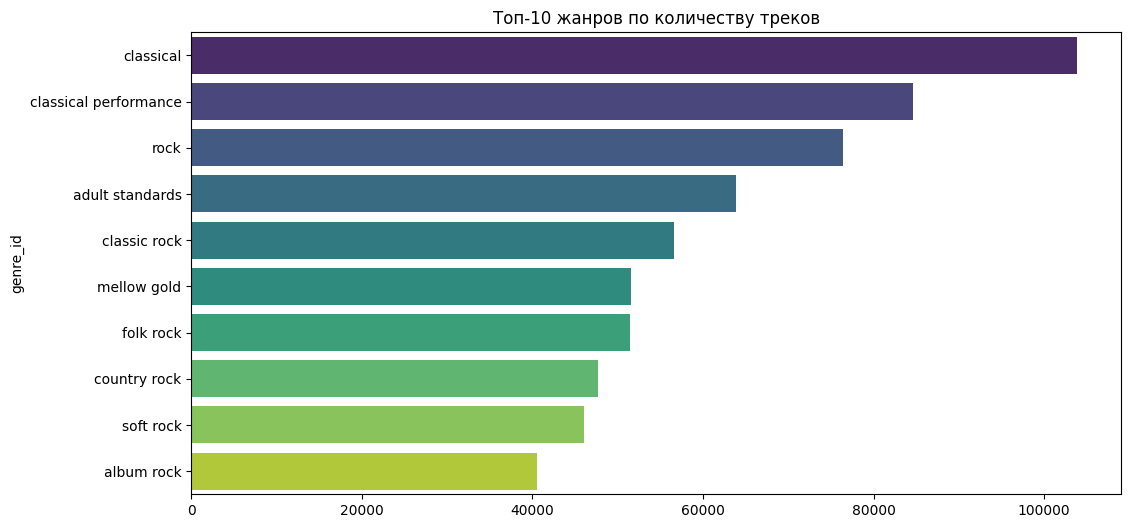

In [43]:
top_genres = merged_generes_data.loc[unique_tracks_index]['genre_id'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(y=top_genres.index, x=top_genres.values, palette="viridis")
plt.title("Топ-10 жанров по количеству треков")
plt.show()

Так, мы значем, что наиболее распространенные жанры для публикаций - это классика и рок, теперь посмотрим на взаимосвязь жанра и популярности треков

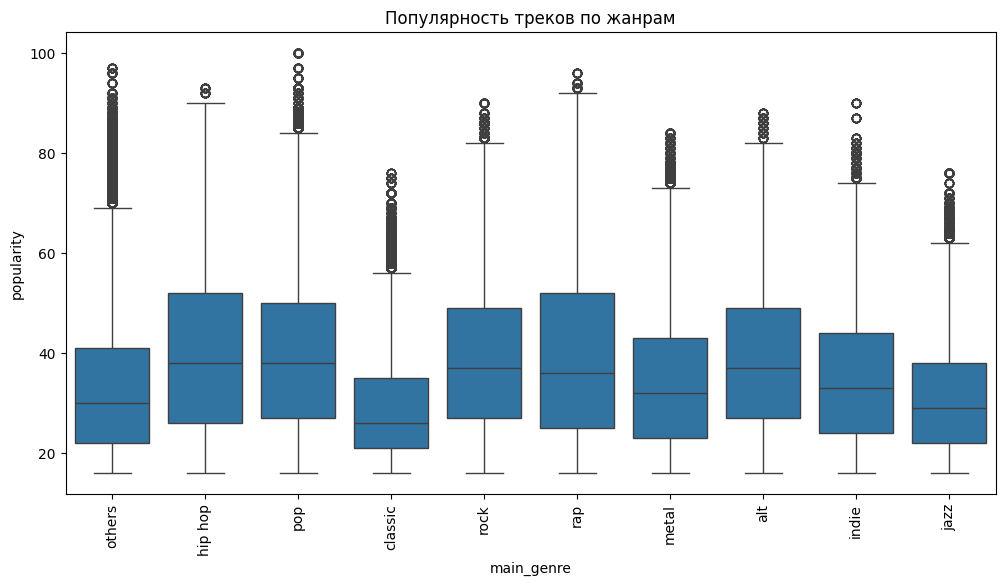

In [45]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_generes_data.loc[unique_tracks_index]
            [merged_generes_data.loc[unique_tracks_index]['main_genre']
                                     .isin(merged_generes_data.loc[unique_tracks_index]
                                           .groupby('main_genre')['popularity'].median()
                                           .sort_values()
                                           .tail(50)
                                           .index
                                                        )]
, x='main_genre', y='popularity')
plt.xticks(rotation=90)
plt.title("Популярность треков по жанрам")
plt.show()


Что интересного показывает этот график.

1. Нижняя планка популярности каждого жанра. Например, рок и альтернатива (исходя из графика) всегда находят своего слушателя
2. Классика очень локальный жанр, но у нее очень много "выстреливающих" авторов. То есть исходя из прошлого графика. Композиции очень много, но моцарт он один. И он очень популрный
3. А, например, у рэпа очень мало "сверх" популярных треков.
4. Металл никогда не может понравится сразу всем. Очень забавная статистика

Корреляционный анализ характеристик треков

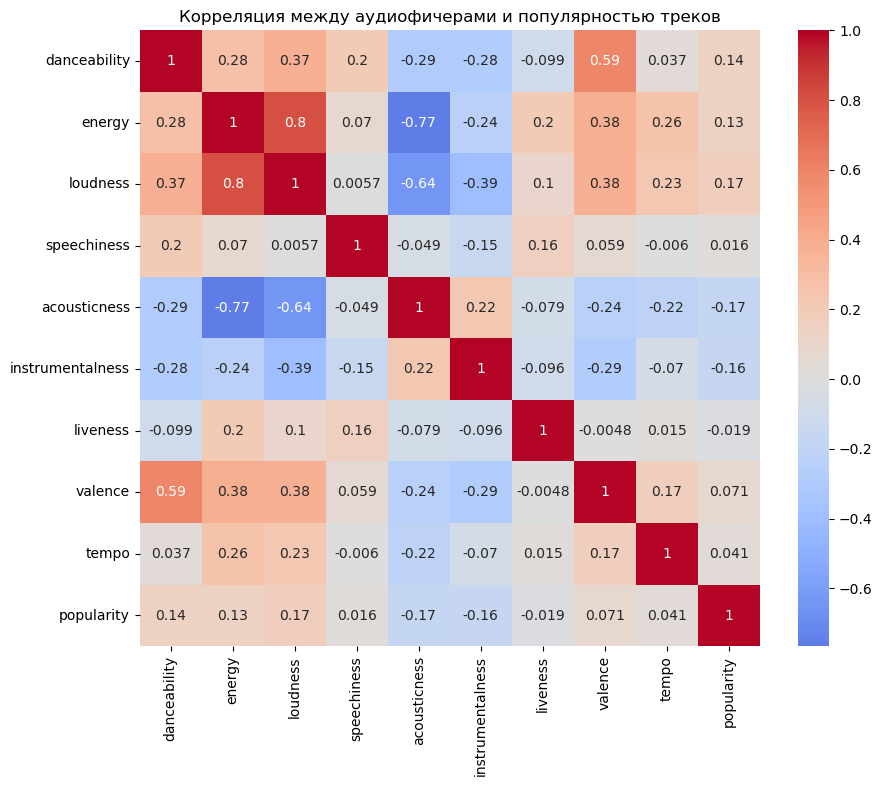

In [ ]:
corr = merged_generes_data.loc[unique_tracks_index][['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                  'instrumentalness', 'liveness', 'valence', 'tempo', 'popularity']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Корреляция между аудиофичерами и популярностью треков")
plt.show()

В данной матрице корреляций музыкальных характеристик треков можно заметить ряд значимых взаимосвязей. Сильная положительная корреляция между энергией и громкостью (`0.80`) указывает на то, что энергичные треки, как правило, играются на более высокой громкости. Валентность, которая отражает эмоциональную окраску музыки, довольно сильно коррелирует с танцевальностью (`0.59`), что подразумевает, что более жизнерадостные треки обычно более танцевальны. Также существует умеренная отрицательная корреляция между акустичностью и громкостью (`-0.64`), что естественно, так как акустические треки обычно записываются на более низких уровнях громкости. Интересно, что акустичность и инструментальность также слегка положительно коррелируют (`0.22`), вероятно, отражая тенденцию инструментальных треков быть менее обработанными и более "чистыми" с акустической точки зрения. Отрицательная корреляция между танцевальностью и акустичностью (`-0.29`) также подтверждает, что более акустические треки реже обладают ярко выраженными ритмами, необходимыми для танцев. Наконец, популярность треков имеет лишь слабые положительные связи с большинством характеристик, например, с громкостью и энергией, что, возможно, свидетельствует о разнообразии вкусов аудитории, ориентированной на популярные треки, и отсутствии предпочтения к конкретным музыкальным параметрам. Многие выводы по данной матрице подтверждаются замечаниями выше и ниже.

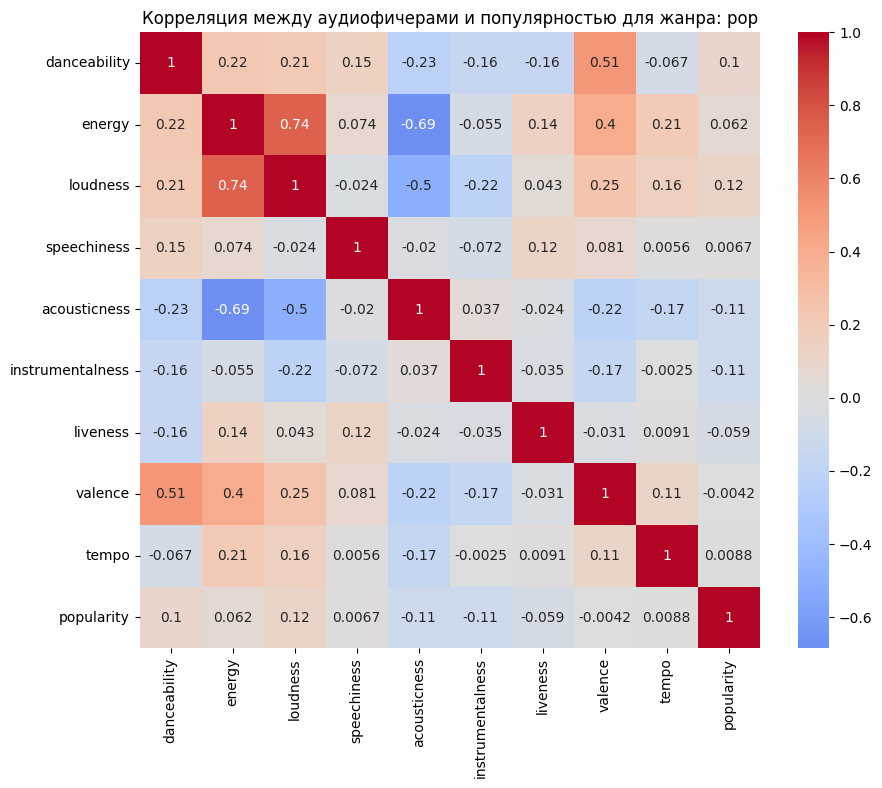

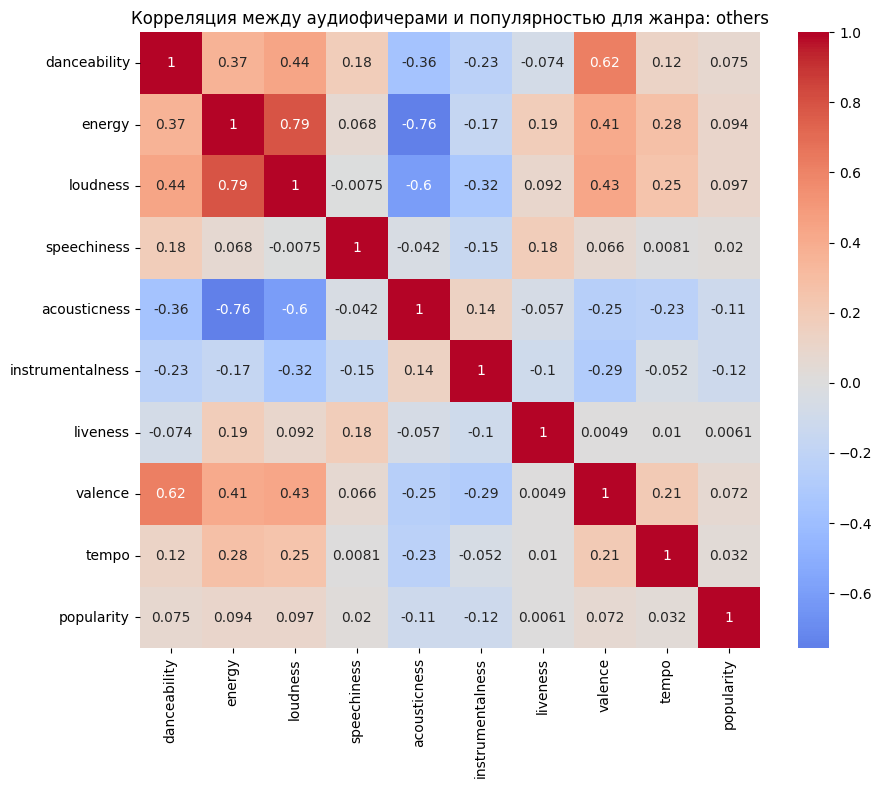

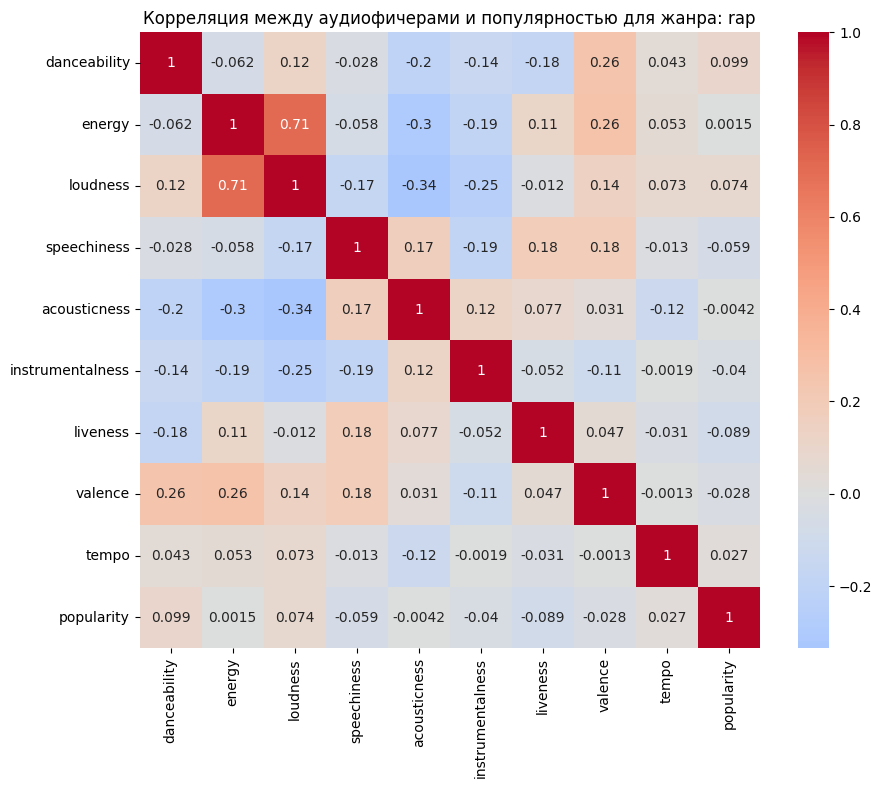

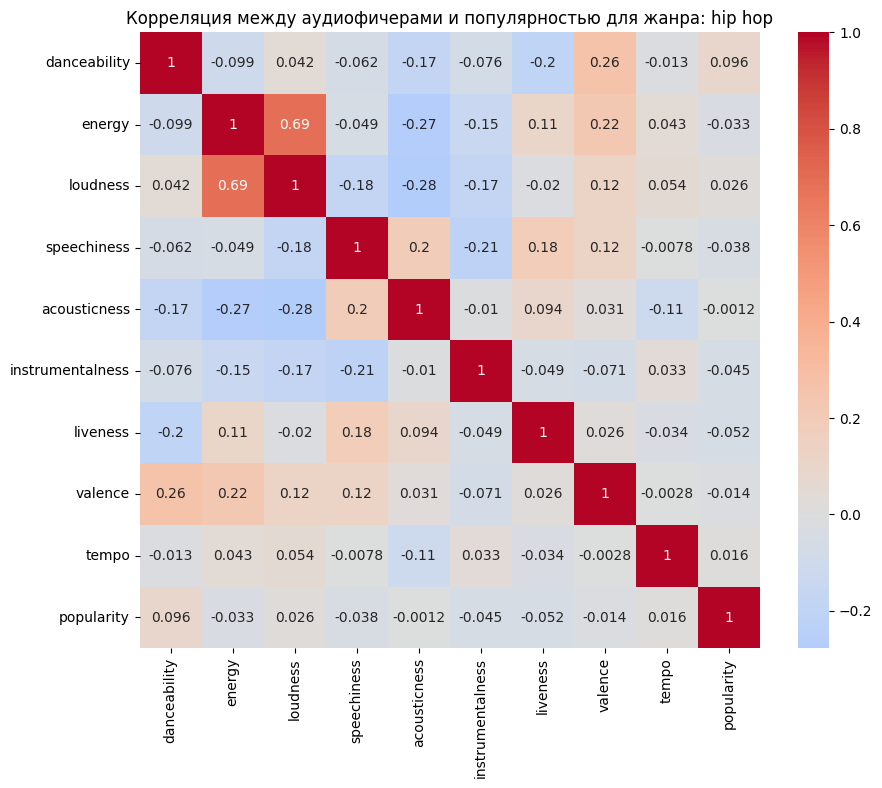

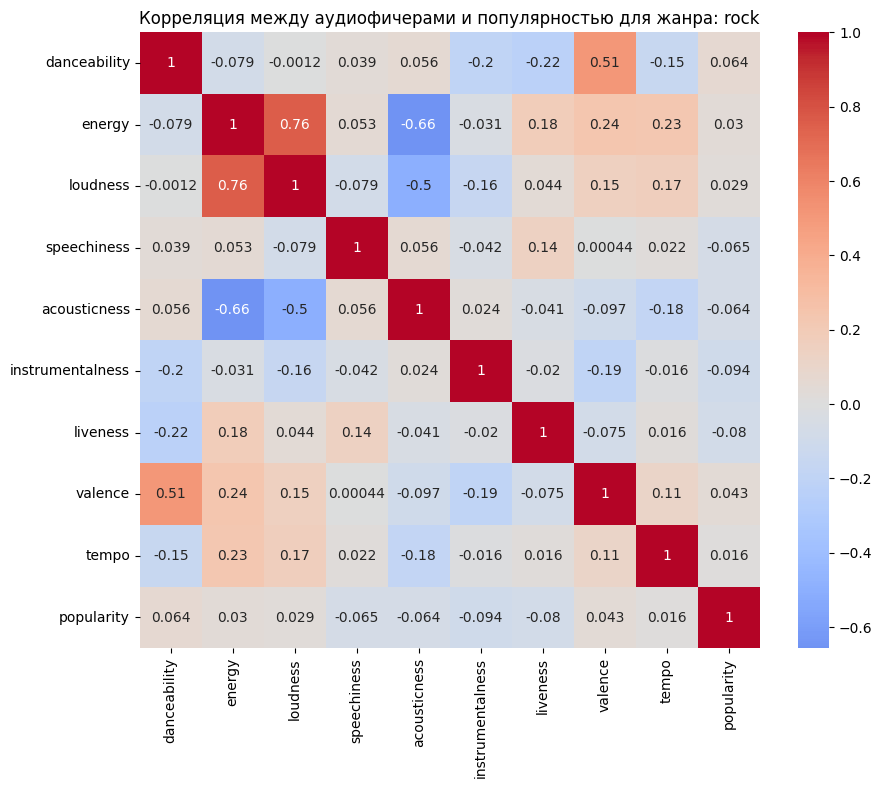

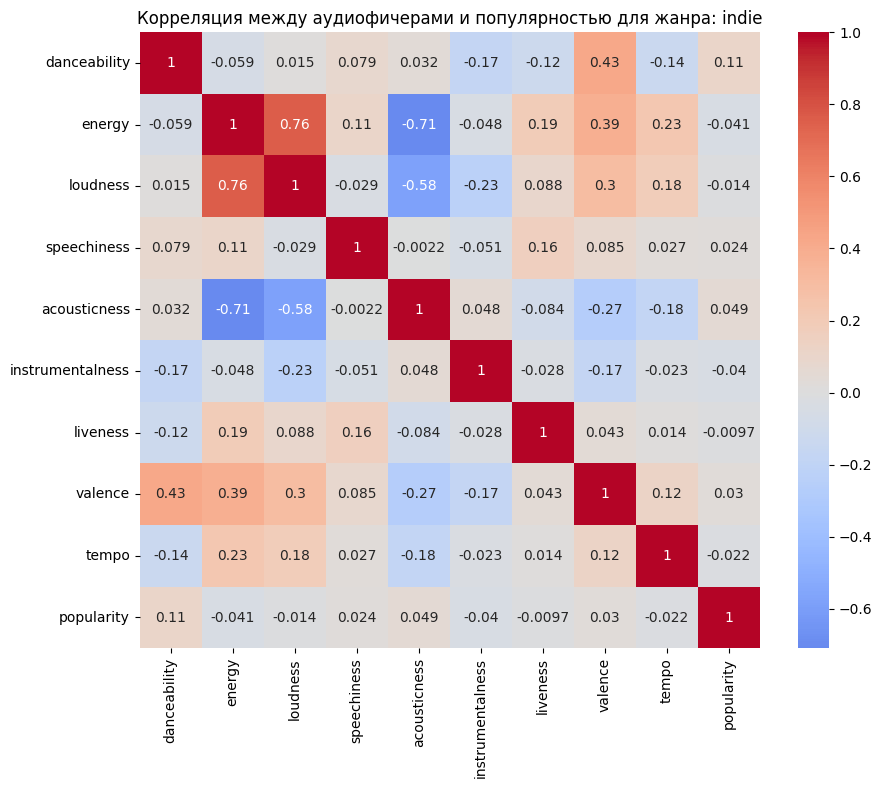

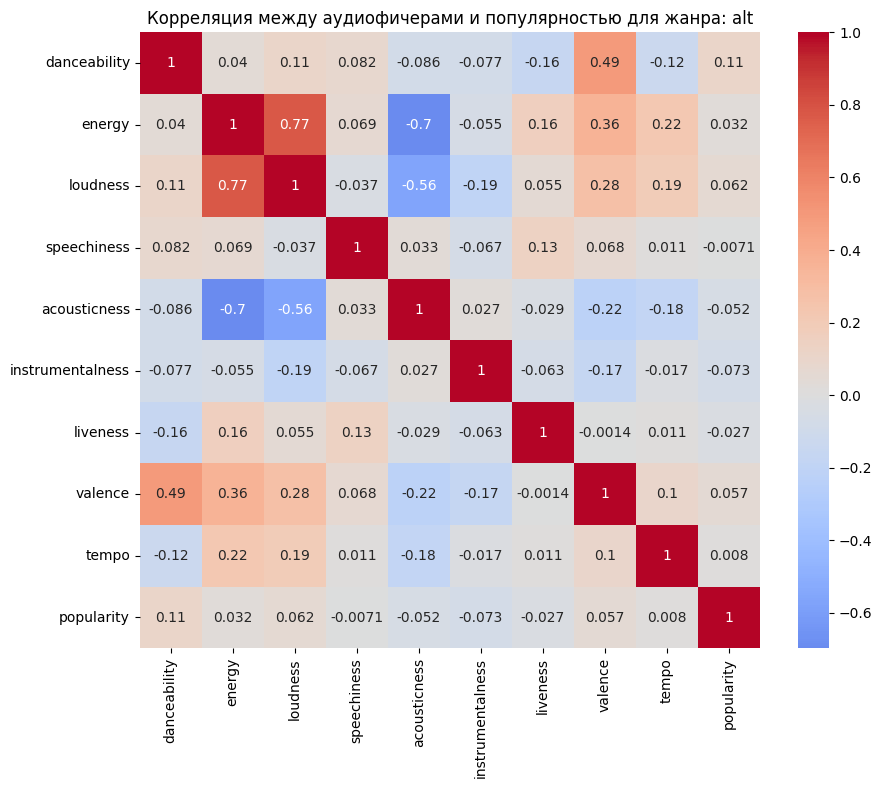

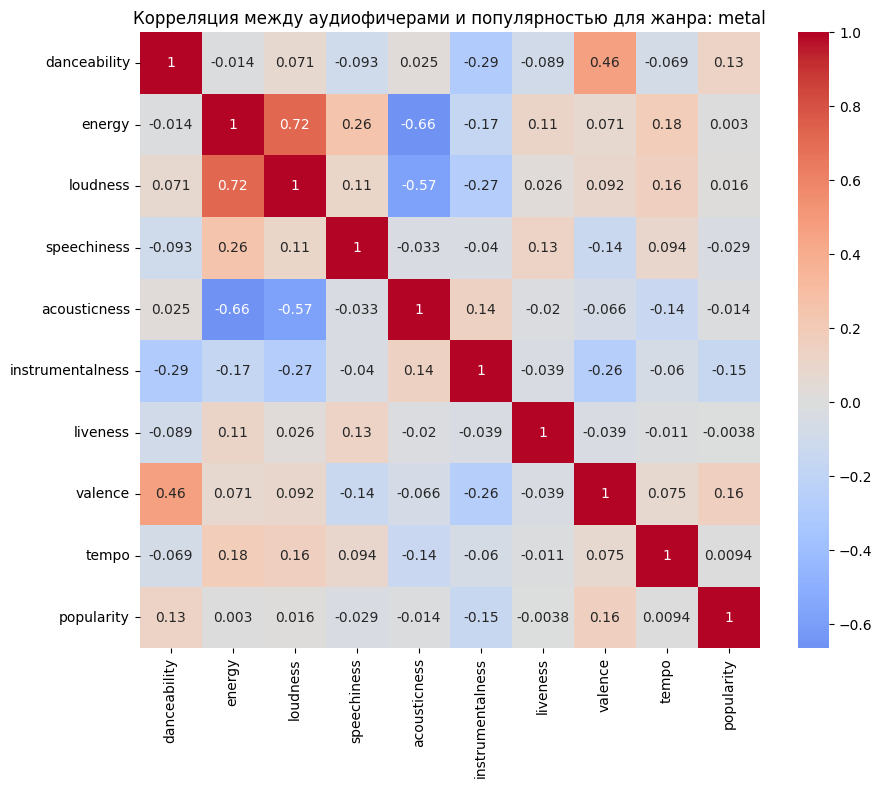

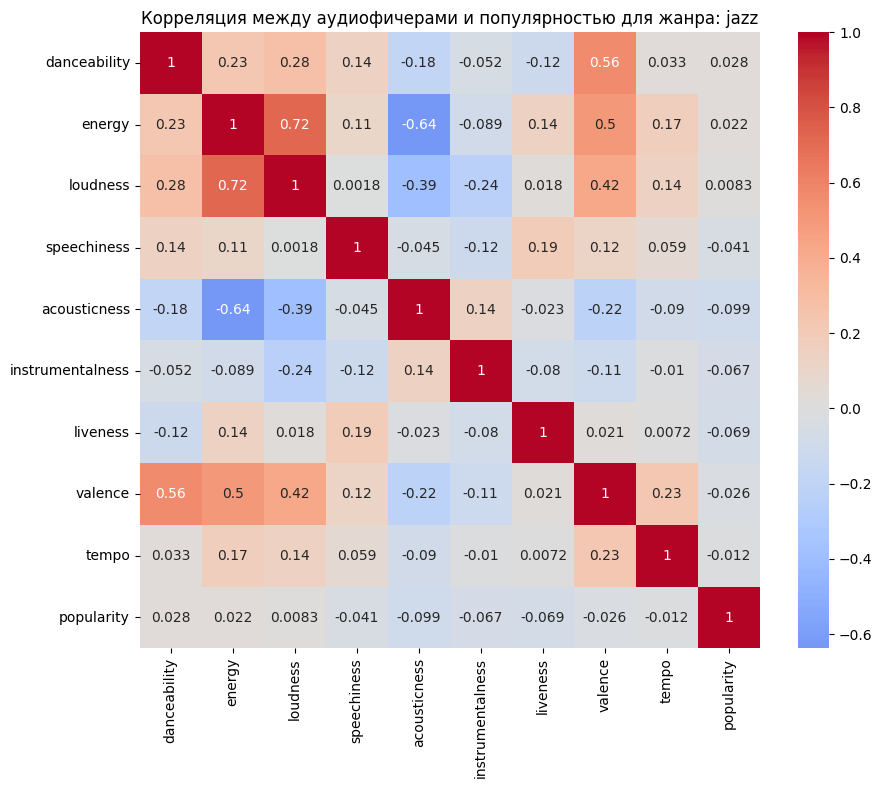

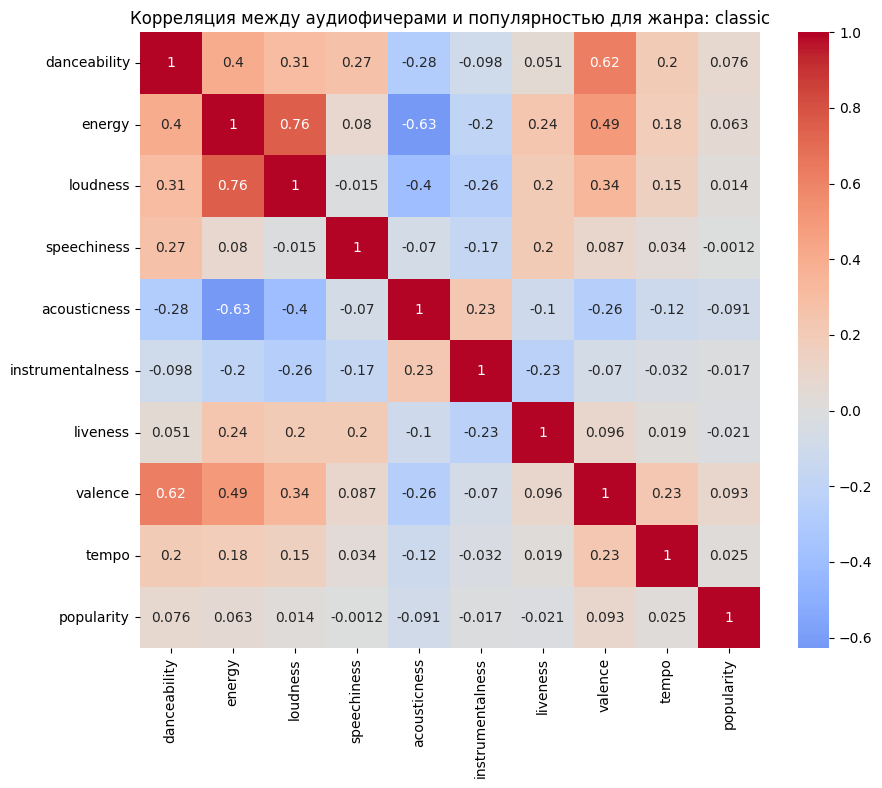

In [46]:
# А теперь разные жанры....
unique_genres = merged_generes_data['main_genre'].unique()

# Цикл по уникальным жанрам для построения корреляционной матрицы
for genre in unique_genres:
    # Фильтруем данные по текущему жанру
    genre_data = merged_generes_data[merged_generes_data['main_genre'] == genre]
    
    # Проверяем, есть ли достаточное количество данных для корреляции
    if len(genre_data) >= 2:  # Необходимо минимум 2 строки для вычисления корреляции
        corr = genre_data[['danceability', 'energy', 'loudness', 'speechiness', 
                           'acousticness', 'instrumentalness', 'liveness', 
                           'valence', 'tempo', 'popularity']].corr()
        
        # Визуализация
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
        plt.title(f"Корреляция между аудиофичерами и популярностью для жанра: {genre}")
        plt.show()
    else:
        print(f"Недостаточно данных для жанра: {genre}")

Если смотреть на разделение по жанрам и всякую корреляцию.

То можно добавить, что для более характерных для жанров характеристик, корреляция увеличивается.

1. Возьмем наличие "istrumentalness" и "acounsticness". Для рэпа такая вещь как инструменты вообще неизвестна. Поэтому корреляции никакой нет. А вот в классике, этих признаки сильно коррелируют
2. "valence" (то есть настроение песни) сильны коррелирует с танцевальностью, именно в классике и в попе. Что тоже логично. Например, если возьмем какой-нибудь канкан, то он веселый и под него танцуют. А в попе... Под грустную танцевать сложно.
3. В джазе настроение музыки, также сильно влияет на энергичность, а вот в металее нет. Там громкость важна. (В металле в целом сложно выделить такой признак, как настроение)
4. В альтернативе, если музыка "акустична", то в ней отсутствует энергичность. Почему? Потому что

Анализ продолжительности треков

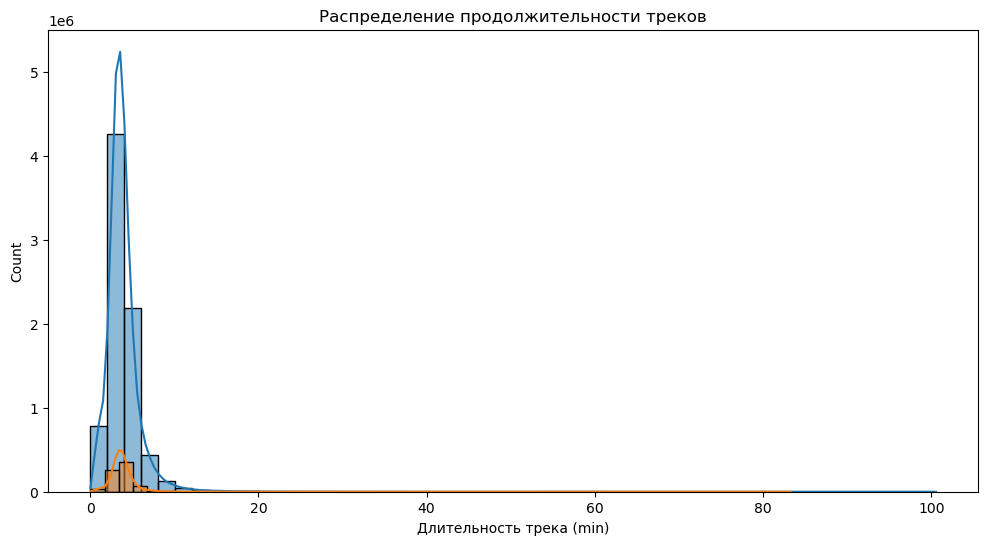

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot((merged_generes_data.loc[unique_tracks_index]['duration'] * 0.001 / 60), bins=50, kde=True)
sns.histplot((merged_generes_data.loc[unique_tracks_index][
    merged_generes_data.loc[
        unique_tracks_index
    ]['popularity'] > merged_generes_data.loc[
        unique_tracks_index
    ]['popularity'].quantile(.9)
]['duration'] * 0.001 / 60), bins=50, kde=True)
plt.title("Распределение продолжительности треков")
plt.xlabel("Длительность трека (min)")
plt.show()
# Хвост обрезать
# Разделить по жанрам...
# Добавить легенду

Пики длительности топа-10% популярных песен и всех песен примерно совпадают, однако первые более кучные вокруг медианы.

Взаимосвязь громкости и энергии

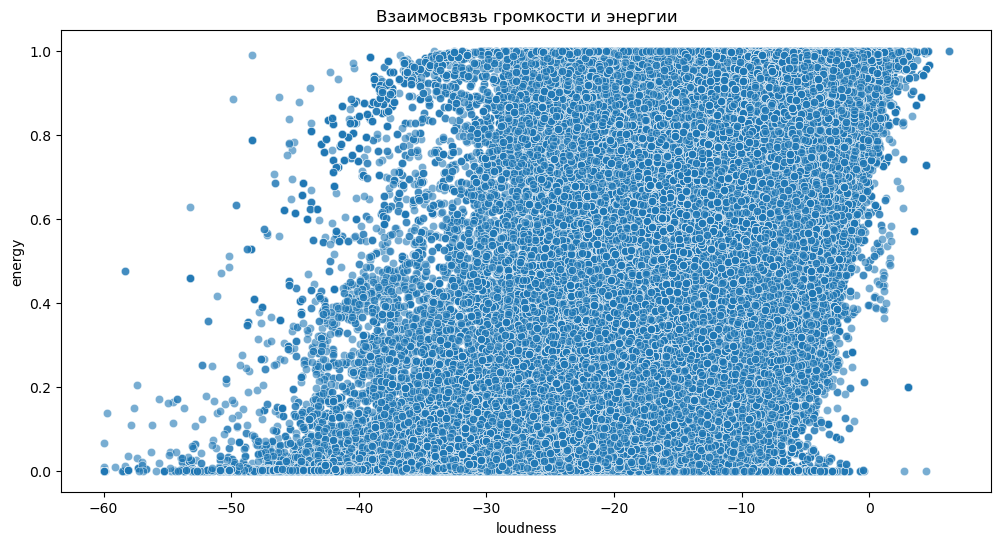

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_generes_data.loc[unique_tracks_index], x='loudness', y='energy', alpha=0.6)
plt.title("Взаимосвязь громкости и энергии")
plt.show()
# Разделить по жанрам...
# Температуру сделать

Как и ожидалось - песни громче более энергичные, стоит учесть при формировании плейлиста для веселой компании.

Взаимосвязь танцевальности и популярности

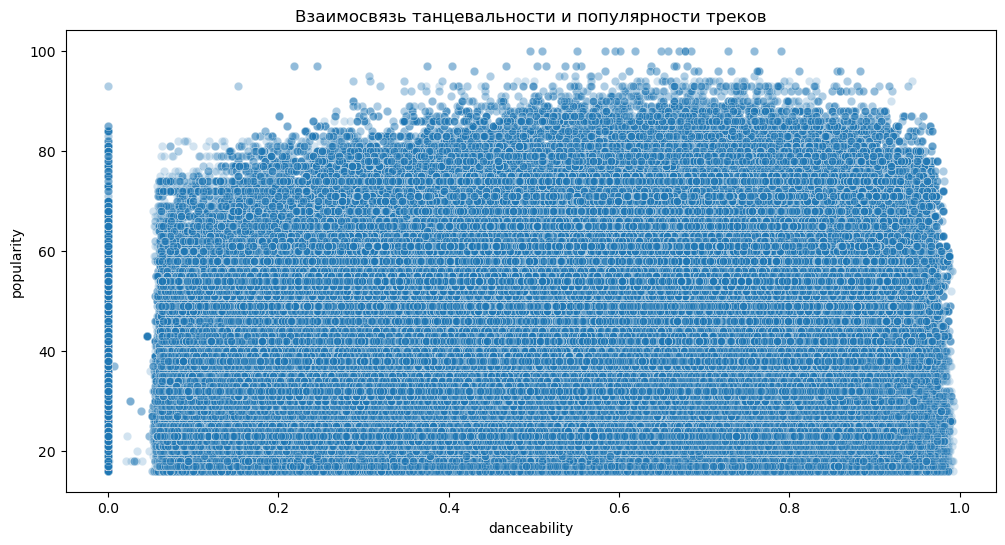

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_generes_data.loc[unique_tracks_index], x='danceability', y='popularity', alpha=0.2)
plt.title("Взаимосвязь танцевальности и популярности треков")
plt.show()

Популярные песни склонны быть более динамичными.

Для анализа "плодовитости" артиста по популярности можно использовать показатель, отражающий, какой процент его треков имеют популярность топ-5%. Этот метод позволит сравнивать артистов не только по числу их треков, но и по их относительной популярности. При этом возьмем артистов с количеством треков больше среднего, чтобы повысить их узнаваемость.

/var/folders/sf/jzrphqn915d65zmft1kp0qv40000gp/T/ipykernel_26889/2992342856.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=artist_popularity.popularity_ratio, y=artist_popularity.index, palette="magma")


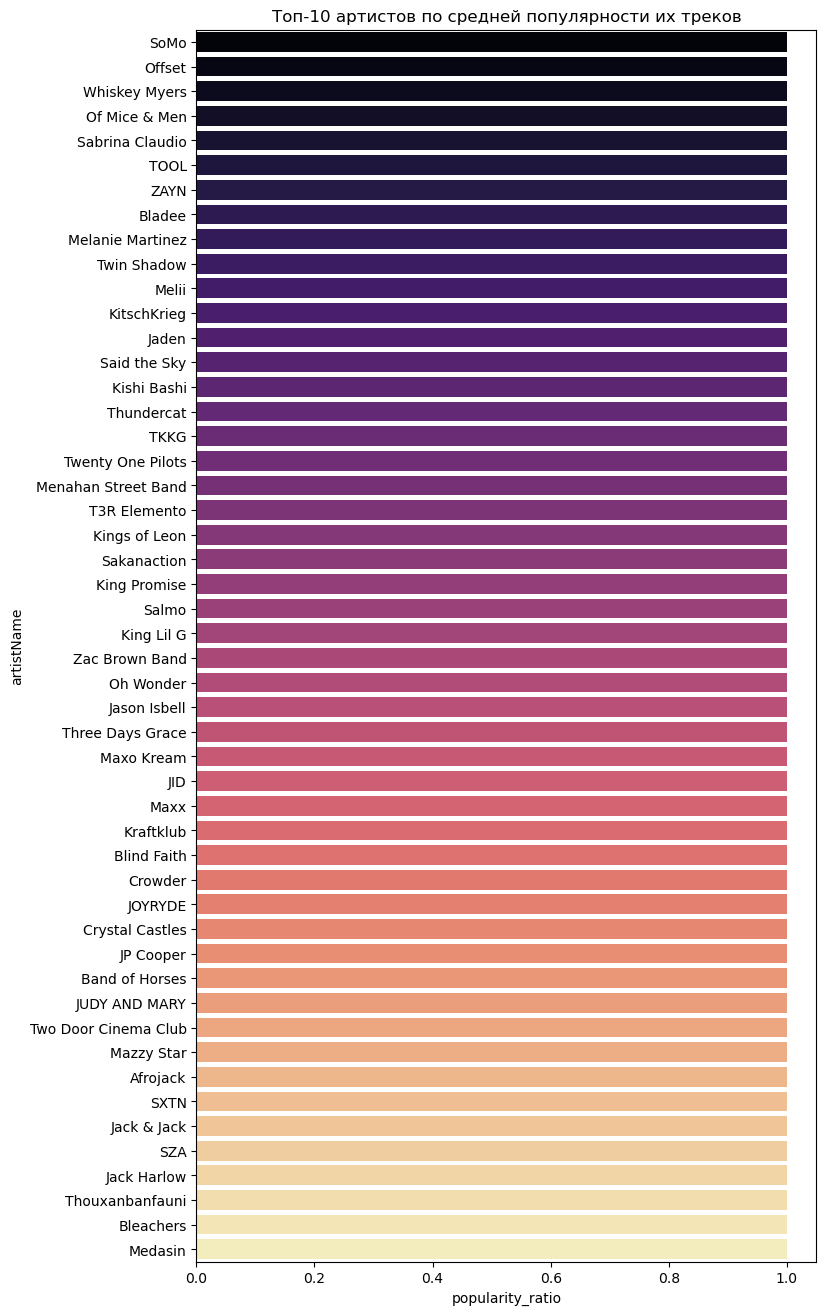

In [ ]:
average_popularity = merged_generes_data['popularity'].quantile(.95)

merged_generes_data['is_popular'] = merged_generes_data['popularity'] > average_popularity
artist_popularity = merged_generes_data.groupby('artistName').agg(
    total_tracks=('track_id', 'size'),
    popular_tracks=('is_popular', 'sum')
)
artist_popularity = artist_popularity[artist_popularity['total_tracks'] > artist_popularity['total_tracks'].mean()]
artist_popularity['popularity_ratio'] = artist_popularity['popular_tracks'] / artist_popularity['total_tracks']
artist_popularity = artist_popularity.sort_values(by='popularity_ratio', ascending=False)

artist_popularity = artist_popularity[['total_tracks', 'popular_tracks', 'popularity_ratio']].head(50)
plt.figure(figsize=(8, 16))
sns.barplot(x=artist_popularity.popularity_ratio, y=artist_popularity.index, palette="magma")
plt.title("Топ-10 артистов по средней популярности их треков")
plt.show()

Можно использовать среднюю популярность треков каждого артиста как метрику, оценивая, насколько популярны их произведения в целом. Это обеспечит большее внимание к артистам, чьи треки имеют высокую совокупную популярность, даже если у них меньше общего количества популярных треков.

/var/folders/sf/jzrphqn915d65zmft1kp0qv40000gp/T/ipykernel_26889/1399311237.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette="magma")


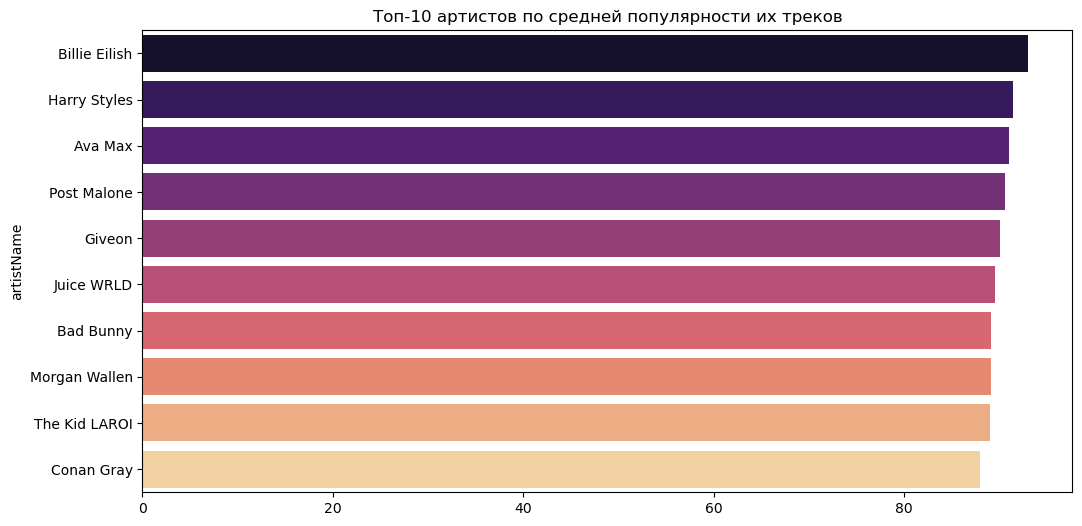

In [ ]:
top_artists = merged_generes_data.groupby('artistName')['popularity'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette="magma")
plt.title("Топ-10 артистов по средней популярности их треков")
plt.show()

# Отмена отмена